# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [4]:
import torch
from torchvision import datasets, transforms

In [6]:
x = datasets.MNIST('data',download=True)
x[0]

Failed to download (trying next):
HTTP Error 403: Forbidden



41.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




91.4%

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [7]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [8]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [9]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

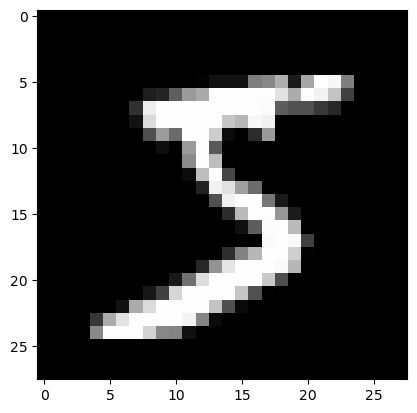

In [11]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

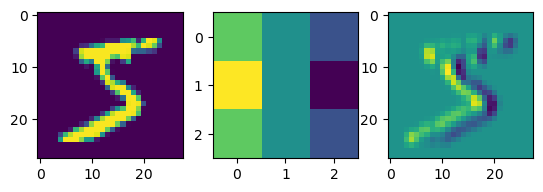

In [12]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [15]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [16]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

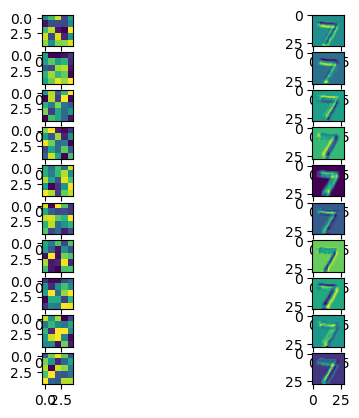

In [17]:
visualize()

# Predict Using Network

In [18]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [19]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([4, 0, 7, 5, 8])

# First Test and Train

In [20]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [21]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 12%



In [22]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [23]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.329226
Train loss: 1.880615
Train loss: 1.081788
Train loss: 1.004368
Train loss: 0.873023
Train loss: 0.672932
Train loss: 0.708552
Train loss: 0.435865
Train loss: 0.450542
Train loss: 0.377773


# Train Network

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.332518
Train loss: 1.938394
Train loss: 1.293312
Train loss: 1.032186
Train loss: 0.787493
Train loss: 0.634814
Train loss: 0.661167
Train loss: 0.560615
Train loss: 0.643268
Train loss: 0.664673
Test accuracy: 94%

Train loss: 0.500212
Train loss: 0.381930
Train loss: 0.359262
Train loss: 0.741889
Train loss: 0.514447
Train loss: 0.266512
Train loss: 0.208861
Train loss: 0.340154
Train loss: 0.434038
Train loss: 0.292649
Test accuracy: 96%

Train loss: 0.314711
Train loss: 0.470449
Train loss: 0.361041
Train loss: 0.665435
Train loss: 0.088861
Train loss: 0.279829
Train loss: 0.254914
Train loss: 0.419467
Train loss: 0.497524
Train loss: 0.261152
Test accuracy: 97%

Train loss: 0.288079
Train loss: 0.270529
Train loss: 0.205467
Train loss: 0.571253
Train loss: 0.188037
Train loss: 0.234145
Train loss: 0.173869
Train loss: 0.409787
Train loss: 0.345020
Train loss: 0.598692
Test accuracy: 97%

Train loss: 0.180527
Train loss: 0.241567
Train loss: 0.209182
Train loss: 0.448

# Inspect Network

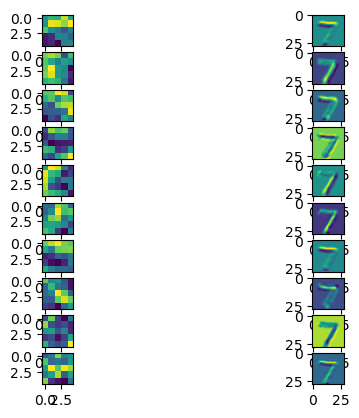

In [25]:
visualize()

In [26]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [27]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [28]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [29]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.314907
Train loss: 2.089247
Train loss: 1.130377
Train loss: 0.848377
Train loss: 0.718921
Test accuracy: 90%

Train loss: 0.681269
Train loss: 0.463791
Train loss: 0.527292
Train loss: 0.545267
Train loss: 0.275273
Test accuracy: 94%

Train loss: 0.410227
Train loss: 0.494939
Train loss: 0.330767
Train loss: 0.700390
Train loss: 0.254750
Test accuracy: 95%

Train loss: 0.352971
Train loss: 0.486422
Train loss: 0.344572
Train loss: 0.470792
Train loss: 0.237155
Test accuracy: 96%

Train loss: 0.548184
Train loss: 0.230506
Train loss: 0.275906
Train loss: 0.342077
Train loss: 0.222340
Test accuracy: 97%



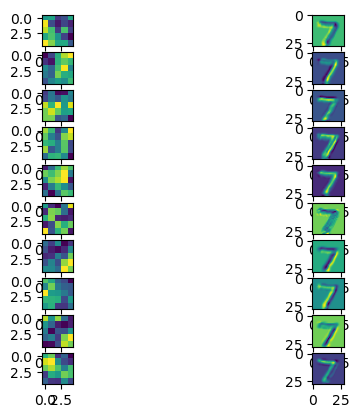

In [30]:
visualize()

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [32]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.357142
Test accuracy: 61%

Train loss: 2.084065
Test accuracy: 82%

Train loss: 1.192112
Test accuracy: 88%

Train loss: 0.813870
Test accuracy: 91%

Train loss: 0.703456
Test accuracy: 92%



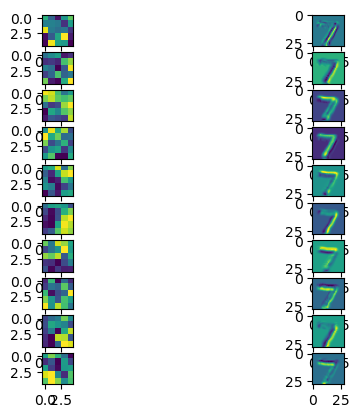

In [33]:
visualize()

In [34]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [35]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.351201
Test accuracy: 32%

Train loss: 2.189756
Test accuracy: 50%

Train loss: 1.908680
Test accuracy: 69%

Train loss: 1.542848
Test accuracy: 80%

Train loss: 1.141504
Test accuracy: 83%



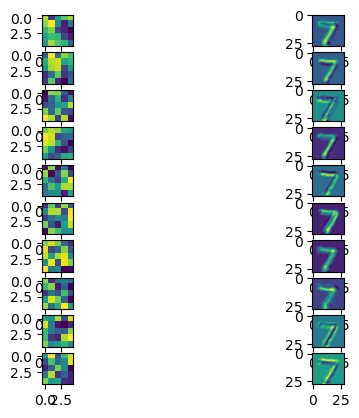

In [36]:
visualize()

In [37]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [38]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_35206/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.346027
Test accuracy: 12%

Train loss: 2.290648
Test accuracy: 20%

Train loss: 2.260591
Test accuracy: 26%

Train loss: 2.235077
Test accuracy: 42%

Train loss: 2.189820
Test accuracy: 47%



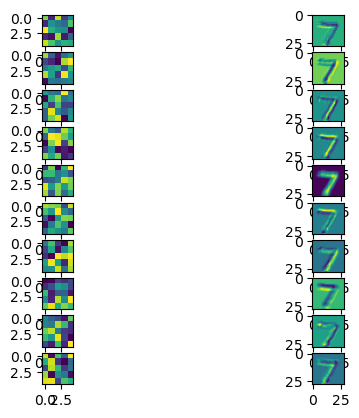

In [39]:
visualize()

1a. What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
So the accuracy using 60,000 images is about 98% 
The accuracy for 30,000 is 97% 
The accuracy for 3000 is 92% 
And the accuracy for 600 is 47%  

1b. How do the weights looks different when trained with 60,000 vs 600?
Well the weights look less coordinated, and more abstract as they are trained with 600 vs the sharp patterns that emerge when they are trained on 60,000. So obviously when these are trained with less they will take less time but will be less accurate and produce worse results. 